# Градски саобраћајни превоз

У овој радној свесци анализираћемо податке о јавном градском превозу у граду Београду. Податке је отворила градска управа града Београда и налазе се на платформи: https://data.gov.rs/sr/datasets/.
Ови подаци садрже информације о свим линијама градског превоза и њихове редове вожње, а њихова анализа је посебно интересантна зато што нам даје информације о структури града, те град можемо упознати индиректно кроз податке. 
Истраживаћемо просторни и временски аспект ових података, специјално:
- истражићемо колико дуго чекамо на превоз, које линије су најфреквентније
- идентификоваћемо линије које су најдуже, у којим деловима града има најмање линија и стајалишта 
- визуализоваћемо просторне податке уз помоћ дводимензионалних хистограма

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Подаци о градском превозу подељени су у више различитих фајлова који садрже информације о временима полазака свих возила градског превоза, стајалиштима за сваку линију и њиховим локацијама. У наставку ћемо учитавати фајлове један по један и анализирати их и по потреби спајати. Крећемо од анализе реда вожње.

## Када је доступан јавни градски превоз?

Учитаћемо за почетак фајл о реду вожње. Учитаваћемо смо податке директно са платформе отворених података, за случај да дође до измене и линија кода за учитавање са урл адресом вам не помаже да учитате податке, фајл је преузет и налази се у локалном фолдеру са подацима (можете га учитати линијом кода која је у коментару).

In [3]:
redvoznje = pd.read_csv('https://data.gov.rs/s/resources/red-vozhnje-javnog-gradskog-prevozha/20180301-154643/RedVoznje.csv')
#redvoznje = pd.read_csv('gsp data/RedVoznje.csv')
redvoznje.head(3)

,ROUTE_CODE,BUS_DUTY_NO,DIRECTION,SCHEDULE_TIME,SCHEDULE_TYPE
0,2,1,forward,410,work day
1,2,1,forward,455,work day
2,2,1,forward,547,work day


У овој табели, дати су нам подаци о линији градског превоза на коју се ред вожње односи *ROUTE_CODE*, времену када превоз креће са почетне станице *SCHEDULE_TIME* као и типу реда вожње *SCHEDULE_TYPE*. Да проверимо шта се крије у овој колони осим радног дана (work day) који видимо у првим уносима искористићемо функцију **unique**:

In [4]:
redvoznje['SCHEDULE_TYPE'].unique()

array(['work day', 'saturday', 'sunday'], dtype=object)

Дакле имамо одвојено ред вожње за радне дане, суботе и недеље! Можемо погледати коришћењем функције **info** који је тип податка у колони *SCHEDULE_TIME*:

In [5]:
redvoznje.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67785 entries, 0 to 67784
Data columns (total 5 columns):
ROUTE_CODE       67785 non-null int64
BUS_DUTY_NO      67785 non-null int64
DIRECTION        67785 non-null object
SCHEDULE_TIME    67785 non-null int64
SCHEDULE_TYPE    67785 non-null object
dtypes: int64(3), object(2)
memory usage: 2.6+ MB


Колона за коју очекујемо да садржи податке о времену препозната је као колона са целобројним вредностима *int64*. Ако погледамо почетак табеле у претходним редовима, видимо да  је време у току дана очитано и уписано без двотачке између сата и минута, тј. 440 уместо 4:40. Да то исправимо, у наставку је функција којом ћемо све те податке превести у целобројане вредности минута протеклих од поноћи:

In [6]:
def vremetomin(t):
    h=t//100 # целобројно дељење са 100 којим преузимамо број сати протекао од поноћи
    m=t-h*100 # остатак су минути
    if t==0:
        return 24*60 # ово је ствар договора, али ћемо у наставку време поласка превоза у поноћ водити као последње могуће време
    else:
        return h*60+m 

Сада ћемо направити нову колону у којој ћемо чувати број протеклих минута од поноћи и њене вредности ћемо добити примењујући нову функцију на колону *SCHEDULE_TIME* користећи функцију **apply**:

In [7]:
redvoznje['Minuti od ponoci'] = redvoznje['SCHEDULE_TIME'].apply(vremetomin)
redvoznje.head(2)

,ROUTE_CODE,BUS_DUTY_NO,DIRECTION,SCHEDULE_TIME,SCHEDULE_TYPE,Minuti od ponoci
0,2,1,forward,410,work day,250
1,2,1,forward,455,work day,295


Сада можемо нацртати хистограм времена полазака аутобуса радним даном и тиме ћемо добити информацију о броју активних возила јавног градског превоза у сваком од временских интервала које посматрамо.

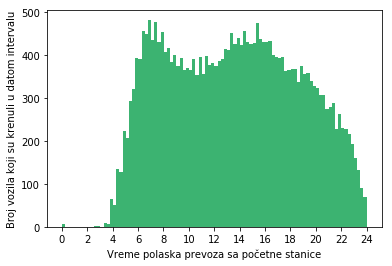

In [8]:
plotdata = redvoznje[(redvoznje['SCHEDULE_TYPE']=='work day')]['Minuti od ponoci']

plt.hist(plotdata,bins=24*4,color='mediumseagreen')
plt.xticks(range(0,25*60,2*60),list(range(0,25,2)))

plt.xlabel('Vreme polaska prevoza sa početne stanice')
plt.ylabel('Broj vozila koji su krenuli u datom intervalu')
plt.show()

Број интервала на х-оси смо подесили користећи (*bins*) и вредношћу 24х4 смо дан поделили на 15-минутне интервале. Такође, на овом графику смо додатно контролисали ознаке на х оси. Вредности колоне над којима смо позвали функцију хистограм су укупни протекли минути од поноћи, што значи да би без контроле ознака на х оси имали бројеве од 0 до 1440 који генерално нису јасно читљиви (пошто посматрач мора константно да врши конверзију у назад да би размишљао о протеклим сатима). Стога смо функцијом **xticks** поставили ознаке на х оси позиционирали на сваких 120 минтуа (2 сата) и означили их бројем протеклих сати а не минута.

Интересантно је да на овом графику видимо на индиректан начин периоде времена када је град буднији и када се и како полако гаси (претпостављајући да је број возила и њихов распоред у времену настали са циљем подмиривања потреба грађана). Видимо да постоје два интервала када је број активних возила већи, у жаргону, шпиц или 'rush hour'.

Користећи функцију **subplot** можемо упоредно нацртати ове графике за сва три различита типа реда вожње (радни дан, суботу и недељу). Прво ћемо направити листу која садржи различите вредности колоне *SCHEDULE_TYPE* а затим ћемо пролазити кроз листу и на освнову вредности селектовати одговарајући део табеле *redvoznje* који ћемо представити хистограмом.

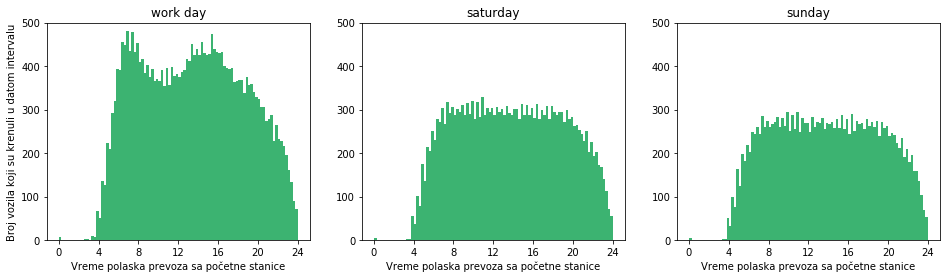

In [9]:
plt.figure(figsize=(16,4))

scheduletypes = list(redvoznje['SCHEDULE_TYPE'].unique())

for i in range(len(scheduletypes)):
    plt.subplot(1,3,i+1)
    plotdata = redvoznje[(redvoznje['SCHEDULE_TYPE']==scheduletypes[i])]['Minuti od ponoci']
    plt.hist(plotdata,24*4,color='mediumseagreen')
    plt.xticks(range(0,25*60,4*60),list(range(0,25,4)))
    plt.ylim([0,500])
    plt.title(scheduletypes[i])
    plt.xlabel('Vreme polaska prevoza sa početne stanice')
    if i==0:
        plt.ylabel('Broj vozila koji su krenuli u datom intervalu')

plt.show()

Поредећи ова три графика (обратита пажњу функцијом **ylim** инсистирали смо на томе да сви графици буду представљени на истој скали, пробајте без овога и видећете како се други и трећи график разликују) примећујемо да је број активних возила из сата у сат мањи током викенда него током радних дана. Током викенда су и упадљиве максимуме у јутарњим и поподневним часовима нестали. Ово има смисла пошто претпстављамо да је пораст броја возила у раним јутарњим и поподневним часовима током радних дана ту да подмири потребе за одлазак и долазак са посла. Било би јако интересантно видети да ли време када има највише градског превоза и даље подмирује потребе радника. Анегдотски, као да сви све више слушамо како се радно време продужило, неретко обухвата и викенд па је питање да ли је разлика између радних дана и суботе оправдана. Али, за одговоре на ова питања мораћемо да сачекамо и неке друге податке који садрже информације о радном времену. (*Додатни коментар: Радно време у јавној управи која запошљава велики број људи је између 7:30 и 15:30.*)

### Колико дуго чекамо на превоз?

Ову информацију ћемо у наставку истражити за једну конкретну линију, а позивамо читаоце да се поиграју и промене кодове превоза и истраже колико се разликују резултати за различите линије.

In [10]:
busNo = 95
listapolazaka = np.sort(redvoznje[(redvoznje['ROUTE_CODE']==busNo)&(redvoznje['DIRECTION']=='forward')&(redvoznje['SCHEDULE_TYPE']=='work day')]['Minuti od ponoci'])
vremedosledecegbusa = [x - listapolazaka[i-1] for i, x in enumerate(listapolazaka)][1:]

Одабиром броја линијије *busNo* у листу *listapolazaka* издвојили смо из реда вожње све поласке само у једном смеру и за један тип реда вожње - радни дан (све смо одабрали по слободном нахођењу, промените ако вас нешто друго више занима).

У листи *vremedosledecegbusa* израчунали смо протекло време између свака два поласка превоза за одабрану линију . Сада ћемо ове податке нацртати на два начина - и као број полазака возила у различитим интервалима током дана, и као број минута између два поласка превоза:

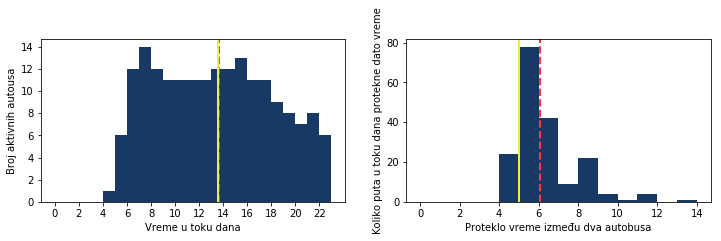

In [11]:
plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
plt.hist(listapolazaka, bins=range(0,24*60,60), color='#183866')
plt.xticks(range(0,24*60,2*60),range(0,24,2));
m = np.mean(listapolazaka)
plt.axvline(x=m,color='#fd383b',linewidth=2,linestyle='dashed')
m = np.median(listapolazaka)
plt.axvline(x=m,color='#eeef3c',linewidth=2)
plt.xlabel('Vreme u toku dana')
plt.ylabel('Broj aktivnih autousa')

plt.subplot(1,2,2)
plt.hist(vremedosledecegbusa,bins=range(max(vremedosledecegbusa)),color='#183866')
m = np.mean(vremedosledecegbusa)
plt.axvline(x=m,color='#fd383b',linewidth=2,linestyle='dashed')
m = np.median(vremedosledecegbusa)
plt.axvline(x=m,color='#eeef3c',linewidth=2)
plt.xlabel('Proteklo vreme između dva autobusa')
plt.ylabel('Koliko puta u toku dana protekne dato vreme')

plt.show()

На левом графику назиру се поново периоди дана када постоји пораст у броју возила због потреба у одласку на радна места. Са десне стране, видимо колико има ситуација када између 2 доласка превоза протекне пар минута, а колико када чекамо пар десетина минута. На оба графика назначене су и просечна (жута пуна линија) и медијална вредност (црвена испрекидана линија) ради поређења.

За даљу анализу, пипремићемо табелу која садржи просечно време између 2 поласка превоза за сваку линију у сету података. То ћемо урадити груписањем по колони *ROUTE_CODE* и селектовањем најмањих и највећих вредности у колони *Minuti od ponoci*.

Како знамо да табела *redvoznje* садржи информације за различите типове реда вожње и знамо да се они значајно разликују, фокусираћемо се само на један (одабрали смо радни дан, али ако вас занима други дан, промените). Такође, претпостављајући да се време чекања на превоз не разликује ако чекате превоз у различитим смеровима, одабрали смо један смер:

In [12]:
deo_redavoznje = redvoznje[(redvoznje['DIRECTION']=='forward')&(redvoznje['SCHEDULE_TYPE']=='work day')]

Издвојићемо први полазак аутобуса користећи функцију **min** над груписаним вредностима по линијама *ROUTE_CODE*. Како операција груписања за продукт увек има табелу која је индексиарана по колони која је коришћена за груписање, ресетоваћемо индекс **reset_index** и доделити име колони у којој су минималне вредности. Проверите шта је различито уколико избаците **reset_index**:

In [13]:
prvi_polazak = deo_redavoznje.groupby('ROUTE_CODE')['Minuti od ponoci'].min().reset_index(name='prvi_polazak')
prvi_polazak.head(2)

,ROUTE_CODE,prvi_polazak
0,2,250
1,3,295


На исти начин ћемо издвојити и последњи полазак и укупан број полазака само ћемо уместо функције **min** користити функције **max** и **size**:

In [14]:
posl_polazak = deo_redavoznje.groupby('ROUTE_CODE')['Minuti od ponoci'].max().reset_index(name='poslednji_polazak')
broj_polazaka = deo_redavoznje.groupby('ROUTE_CODE')['Minuti od ponoci'].size().reset_index(name='broj_polazaka')

Коначно, желимо да спојимо ове табелице у једну која ће садржати све ове податке за различите линије у виду одвојених колона. За то користимо функцију **merge**:

In [15]:
temp_data_per_line = pd.merge(prvi_polazak,posl_polazak,on='ROUTE_CODE')
temp_data_per_line = pd.merge(temp_data_per_line,broj_polazaka,on='ROUTE_CODE')
temp_data_per_line.head(2)

,ROUTE_CODE,prvi_polazak,poslednji_polazak,broj_polazaka
0,2,250,1430,106
1,3,295,1395,106


Срачунајмо сада просечно време чекања између два проласка аутобуса. Између другог и првог поласка прође \\(t_2-t_1\\) минута, између трећег и другог \\(t_3-t_2\\),... између последњег и претпоследњег \\(t_{N}-t_{N-1}\\). Да срачунамо просечно време сабраћемо све ове вредности и поделити са њиховим укупним бројем (N-1). Сабирање свих вредности доводи до великог броја скраћивања те нам остаје само време последњег и првог поласка, што смо већ издвојили. Стога, просечно време је:

In [16]:
temp_data_per_line['Prosecno vreme cekanja'] = (temp_data_per_line['poslednji_polazak']-temp_data_per_line['prvi_polazak'])/(temp_data_per_line['broj_polazaka']-1)
temp_data_per_line.head(2)

,ROUTE_CODE,prvi_polazak,poslednji_polazak,broj_polazaka,Prosecno vreme cekanja
0,2,250,1430,106,11.238095
1,3,295,1395,106,10.476190


Колико мислите да је најкраће/најдуже време чекања, које су то линије? Проверите своју интуицију прегледајући новосрачунату колону!

In [17]:
# место за ваш код

In [18]:
# место за ваш код

## Куда саобраћа јавни градски превоз?

Сада када смо видели да неке линије чешће саобраћају од других, желели бисмо да знамо да ли је то некако везано за локације које посећују. Добра ствар је што имамо податке о простору на коме саобраћа градски превоз. Учитајмо прво фајл који садржи информације о стајалиштима по линијама:

In [19]:
daljinarlinija = pd.read_csv('https://data.gov.rs/s/resources/daljinar-linija-javnog-gradskog-prevoza/20180301-153600/DaljinarLinija.csv',encoding='utf-16',sep='\t')
#daljinarlinija=pd.read_csv('tekst data/daljinarlinija.csv')
daljinarlinija.head(3)

,ROUTE_CODE,BUS_STOP_ID,SEQ_NUMBER,DISTANCE_FROM_FIRST_BUS_STOP,DIRECTION
0,2,7,1,0.0,forward
1,2,5,2,751.0,forward
2,2,71,3,1488.0,forward


За сваку линију (такође означену кодом *ROUTE_CODE*), у овој табели имамо сва стајалишта назначена својим кодовима *BUS_STOP_ID*, редним бројем (од почетка линије *SEQ_NUMBER*) и удаљеношћу од почетка линије *DISTANCE_FROM_FIRST_BUS_STOP*.

Можемо проверити да ли у овој табели имамо различита возила која стају на исто стајалиште (њега смо произвољно одабрали користећи *BUS_STOP_ID*):

In [20]:
daljinarlinija[daljinarlinija['BUS_STOP_ID']==1]

,ROUTE_CODE,BUS_STOP_ID,SEQ_NUMBER,DISTANCE_FROM_FIRST_BUS_STOP,DIRECTION
87,5,1,22,7591.0,backward
287,10,1,24,9681.0,backward
375,11,1,22,10998.0,backward
11242,20002,1,1,0.0,forward
11255,20002,1,14,6710.0,backward
11319,20005,1,13,4281.0,backward
12849,21009,1,29,13671.0,backward


Користећи функцију **value_counts** можемо избројати колико се пута свака јединствена вредност појавила у колони *BUS_STOP_ID* (колико редова који одговарају другим превозима стаје на исту станицу):

In [21]:
broj_vozila_po_stajalistu = daljinarlinija['BUS_STOP_ID'].value_counts()
broj_vozila_po_stajalistu.head()

495    35
496    35
503    34
295    32
498    29
Name: BUS_STOP_ID, dtype: int64

На неким стајалиштима стаје чак 35 различитих линија градског превоза!

Међутим иако је информација о разноврстности превозних линија на једној локацији значајна, интересано би било да знамо да ли су стајалишта често посећена, тј. колико често туда пролази превоз.
Ово можемо израчунати користећи нашу претходну анализу редова вожње градског превоза. Претходно смо за сваку линију избројали колико пута саобраћа током дана - стога знамо да је исти број пута посећена и свака станица на тој траси. Сада можемо за свако стајалиште сабрати број полазака сваког превоза који користи стајалиште и тако ћемо добити број стајања на датој станици у току дана.
Хајде прво да спојимо податке из ове две табеле:

In [22]:
merged_table = pd.merge(daljinarlinija, temp_data_per_line[['ROUTE_CODE','broj_polazaka']], on='ROUTE_CODE',how='outer')
merged_table.head(2)

,ROUTE_CODE,BUS_STOP_ID,SEQ_NUMBER,DISTANCE_FROM_FIRST_BUS_STOP,DIRECTION,broj_polazaka
0,2,7.0,1.0,0.0,forward,106.0
1,2,5.0,2.0,751.0,forward,106.0


Овде смо у функцији **merge** додали аргумент *how* којим смо дефинисали да се све линије нађу у новој табели без обзира да ли се налазе само у једној или у обе табеле (подразумеваном вредношћу овог аргумента у новонасталој табели налазе се само подаци за линије које се налазе и у једној и у другој табели). 
Хајде да видимо део новонастале табеле за исто стајалиште које смо посматрали претходно:

In [23]:
merged_table[merged_table['BUS_STOP_ID']==1]

,ROUTE_CODE,BUS_STOP_ID,SEQ_NUMBER,DISTANCE_FROM_FIRST_BUS_STOP,DIRECTION,broj_polazaka
87,5,1.0,22.0,7591.0,backward,94.0
287,10,1.0,24.0,9681.0,backward,77.0
375,11,1.0,22.0,10998.0,backward,47.0
11242,20002,1.0,1.0,0.0,forward,NaN
11255,20002,1.0,14.0,6710.0,backward,NaN
11319,20005,1.0,13.0,4281.0,backward,NaN
12849,21009,1.0,29.0,13671.0,backward,NaN


Видимо да неке линије нисмо имали у подацима о реду вожње па је стога број полазака за те линије *NaN*. Али то је ок, непотпуни подаци су честа појава, проценићемо посећеност стајалишта на основу података које имамо.

Сада ћемо груписати ову табелу по стајалиштима (*BUS_STOP_ID*) и сумирати број пролазака (проверите на примеру претходно излистаног стајалишта да ли је сума она коју очекујете):

In [24]:
passes_by_stop = merged_table.groupby('BUS_STOP_ID')['broj_polazaka'].sum()
passes_by_stop.head(2)

BUS_STOP_ID
1.0    218.0
2.0    218.0
Name: broj_polazaka, dtype: float64

Хајде да сортирамо ову табелу и виидмо колико често су посећена најпопуларнија стајалишта:

In [25]:
passes_by_stop.sort_values(ascending=False).head()

BUS_STOP_ID
298.0    1751.0
503.0    1607.0
148.0    1564.0
149.0    1564.0
495.0    1526.0
Name: broj_polazaka, dtype: float64

Импресивно, на стајалиште са највише пролазака стане преко 1700 возила током дана! 
Како смо претходно видели да је превоз активан око 20 сати дневно (између 4 ујутру и поноћи), хајде да срачунамо колико секунди у просеку прође без возила на овој станици:

In [26]:
20*60*60/1751

41.11936036550543

У просеку, једном у 41 секунде један превоз стане на стајалиште са редним бројем 298! (Не заборавите, како је ово просечна вредност, сигурно се дешава да некад између два превоза прође више, али и мање од 40 секунди!)

Иако имамо знање о удаљеностима између станица и броју возила која стају на њима, сада бисмо желели да знамо где се та стајалишта налазе. Ти подаци крију се у следећој табели:

In [27]:
stajalista = pd.read_csv('https://data.gov.rs/s/resources/stajalishta-javnog-gradskog-prevoza/20180301-153859/Stajalista.csv',encoding='utf-16',sep='\t')
#stajalista = pd.read_csv('tekst data/Stajalista.csv')
stajalista.head(3)

,BUS_STOP_ID,NAME,LATITUDE,LONGITUDE,ZONE_ID
0,1,Калемегдан (Доњи град),44.826810,20.453274,1
1,2,Тадеуша Кошћушка,44.825917,20.455243,1
2,3,Тадеуша Кошћушка,44.826253,20.454967,1


Супер, сада за сваки код аутобуског стајалишта имамо тачну локацију (географску ширину и дужину), као и име и зону.
Додаћемо овим информацијама и колону о популарности стајалишта, тј. броју дневних посета које смо претходно срачунали:

In [28]:
stajalista = pd.merge(stajalista,passes_by_stop,on='BUS_STOP_ID',how='outer')
stajalista.head(2)

,BUS_STOP_ID,NAME,LATITUDE,LONGITUDE,ZONE_ID,broj_polazaka
0,1,Калемегдан (Доњи град),44.826810,20.453274,1.0,218.0
1,2,Тадеуша Кошћушка,44.825917,20.455243,1.0,218.0


Сада можемо да идентификујемо стајалиште са највише посета:

In [29]:
stajalista[stajalista['BUS_STOP_ID']==298]

,BUS_STOP_ID,NAME,LATITUDE,LONGITUDE,ZONE_ID,broj_polazaka
297,298,Бранков мост,44.815007,20.452724,1.0,1751.0


Неко ко мало познаје град Београд, препознаје име ове станице - у питању је станица у близини моста који спаја Нови Београд и Земун са центром града. 

У наставку ћемо истражити где се налазе и остале станице и колико густо су распрострањене по граду.

### Где се налазе стајалишта градског превоза?

Прво ћемо представити податке о стајалиштима користећи функцију **scatter**. Користићемо поратке о географској ширини и дужини (енг. latitude, longitude) као х и у координате тачака на графику, док ћемо их обојити у по зони којој стајалиште припада:

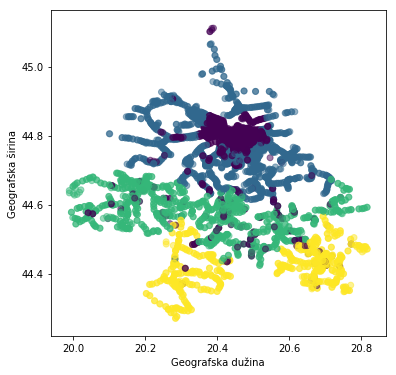

In [30]:
plt.figure(figsize=(6,6))
plt.scatter(stajalista['LONGITUDE'],stajalista['LATITUDE'],c=stajalista['ZONE_ID'],alpha=0.5)
plt.xlabel('Geografska dužina')
plt.ylabel('Geografska širina')
plt.show()

Јако је интересантно што препознајемо град и без постојања мапе испод ових података. Видимо обрисе града и мрежу улица, можемо наслутити и где је центар, а можда и препознати неке од јасних дугих путева изван центра града (да ли нешто препознајете?). Видимо да је централни део града (тамно плаво) скоро у потпуности прекривен кружићима и ту доста теже видимо различите улице. Искористили смо при цртању опцију *alpha* да кружиће учинимо делимично транспарентним и тако видимо разлику између места где постоји само једно или више стајалишта, међутим има превише стајалишта да би нам то помогло.
Видимо такође да су нека стајалишта обојена тамно плавом бојом иако су у потпуности окружена другим бојама и удаљена од центра. Вероватно је по среди грешка у означавању зона стајалишта, али нас ово не брине пуно обзиром да нећемо пуно користити податке о зони стајалишта. 

Сада можемо погледати и исте ове податке, али обојене по броју возила која стају на одговарајуће стајалиште у току једног дана:

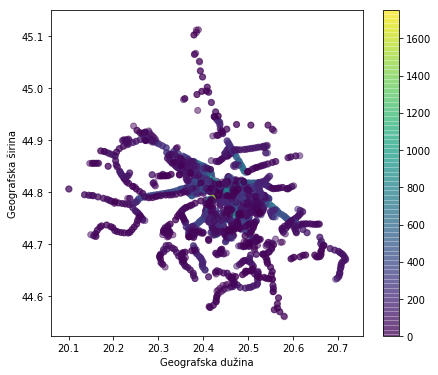

In [31]:
plt.figure(figsize=(7,6))
plt.scatter(stajalista['LONGITUDE'],stajalista['LATITUDE'],c=stajalista['broj_polazaka'],alpha=0.5)
plt.xlabel('Geografska dužina')
plt.ylabel('Geografska širina')
plt.colorbar()

plt.show()

Прво примећујемо да је опсег и број тачкица (стајалишта) на овом графику мањи него на претходном (упоредите на пример опсег у-осе). Ово је вероватно последица тога што за неке линије нисмо имали ред вожње па нисмо пронашли број полазака са почетне станице, те су те тачке избачене са графика.

Друго, ако желимо да пронађемо где су најпопуларнија стајалишта - то је на овом графику јако тешко. Иако легенда указује на постојање и жутих тачкица, оне су у потпуности прекривене осталим мање посећеним стајалиштима. Можемо пробати да смањимо опсег х и у осе и да тако видимо шта се дешава у центру:

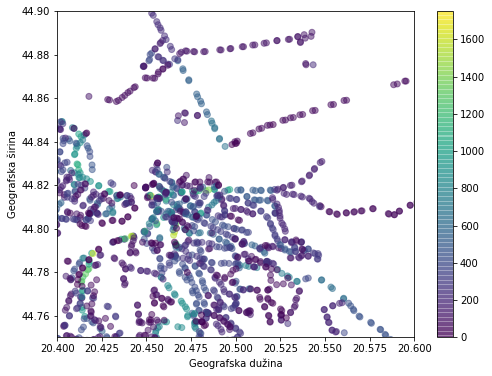

In [32]:
plt.figure(figsize=(8,6))
plt.scatter(stajalista['LONGITUDE'],stajalista['LATITUDE'],c=stajalista['broj_polazaka'],alpha=0.5)
plt.xlabel('Geografska dužina')
plt.ylabel('Geografska širina')
plt.colorbar()
plt.xlim([20.4,20.6])
plt.ylim([44.75,44.9])
plt.show()

На овом графику видимо и неке од популарних стајалишта (жути кружићи) и сјајно је што овим зумирањем видимо боље мрежу централнијих улица. Међутим, тачкасти дијаграм није најбољи избор за представљање ових информација - највише због великог броја преклапања тачкица које не можемо да проценимо. Али постоји начин да заобиђемо овај проблем другачијим визуализацијама.

Да мотивишемо нову врсту дијаграма који ћемо искористити, хајде прво да погледамо колико су уопште честа стајалишта са преко 1200 посета дневно (како смо приметили да градски превоз ради 20 сати, ово у средњем одговара једном возилу у сваком  минуту). Да видимо овакве информације обично смо користили функцију **hist** да избројимо стајалишта за сваки одређен бро посета и резултат прикажемо у виду стубичастог дијаграма:

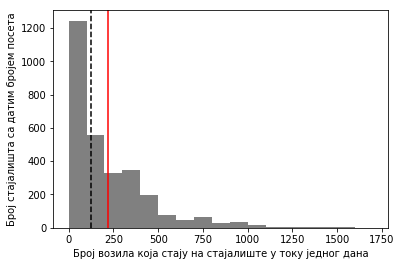

In [33]:
to_plot = stajalista[stajalista['broj_polazaka']>0]['broj_polazaka']
plt.hist(to_plot,range(0,1800,100),color='grey')
plt.axvline(x=np.mean(to_plot),color='red')
plt.axvline(x=np.median(to_plot), color='black',linestyle='dashed')
plt.xlabel('Број возила која стају на стајалиште у току једног дана')
plt.ylabel('Број стајалишта са датим бројем посета')
plt.show()

Видимо да су стајалишта се посетама чешћим од једном у минуту веома ретка. У ствари, већина станица има мање од 100 посетау току дана, што је отприлике 5 пута на сат. Као и раније на график смо унели и просечну вредност (црвена пуна линија) и медијалну вредност (црна испрекидана линија).

Слично као и на хистограму, када имамо дводимензионалне (у овом случају просторне) податке, користећи **hist2d** можемо рачунати колико аутобуских стајалишта припада одређеним просторним јединицама. Цртајући хистограме смо бројали колико има стајалишта са мање од 100 дневних посета, колико са мање од 200, 300 посета, итд. У случају дводимензионалних хистограма простор је подељен на квадрате (или правоугаонике) и бројимо колико је аутобуских станица унутар сваког од њих.

О 2Д хистограму можете размишљати као да постављате прозирну решетку на тачкасти дијаграм који смо претходно нацртали, а затим бројите тачкице у сваком квадратићу решетке. Помоћу аргумената *bins* можете контролисати тачне положаје вертикалних и хоризонталних линија такве решетке или само укупан број њих. Овај број може бити исти за обе осе или различит - ако аргументу *bins* доделите само један број, претпоставља се да распон х и у осе дели истим бројем линија, али можете поставити и *bins* = [100,150], и тако имати више вертикалних него хоризонталних линија у овој замишљеној решеци.
Хајде да видимо 2Д хистограм стајалишта:

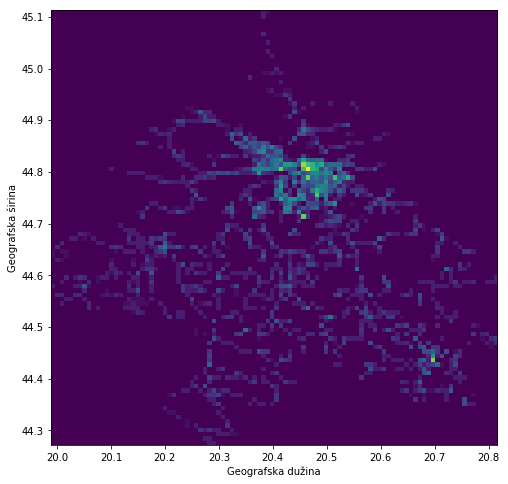

In [34]:
plt.figure(figsize=(8,8))
toplot = stajalista[['LONGITUDE','LATITUDE']].dropna()
plt.hist2d(toplot['LONGITUDE'], toplot['LATITUDE'], bins=100)
plt.xlabel('Geografska dužina')
plt.ylabel('Geografska širina')
plt.show()

За почетак смо нацртали основну верију 2Д хистограма, само смо задали опциони аргумент *bins* на 100 једнаких интервала (без овог додатка подразумевана вредност за *bins* је 10).
Обратите пажњу да смо за цртање издвојили само колоне које садрже географску ширину и дужину и функцијом **dropna** елиминисали евентуалне редове који садрже *NaN* вредности.

Видимо да су региони на овој слици другачије обојени и по њиховом распореду у складу са нашим познавањем података на основу тачкастог дијаграма, претпостављамо да различите боје одговарају различитом броју стајалишта у квадратићу али не знамо која нијанса одговара ком броју. То ћемо решити **colorbar** функцијом која ће додати неку врсту легенде, односно учиниће визуелно јасним пресликавање из боја у бројеве.

У следећој верзији дијаграма, смањићемо и опсег посматраних географских ширина и дужина, повећаћемо број квадратића и променићемо палету боја (користећи аргумент *cmap*, [овде](https://matplotlib.org/tutorials/colors/colormaps.html) можете наћи још идеја за палете боја) са циљем да добијемо још бољи преглед активних региона у граду. Играјте се са мењањем свих ових параметара уколко вас занима неки други део града или хоћете да видите детаљнију мапу.

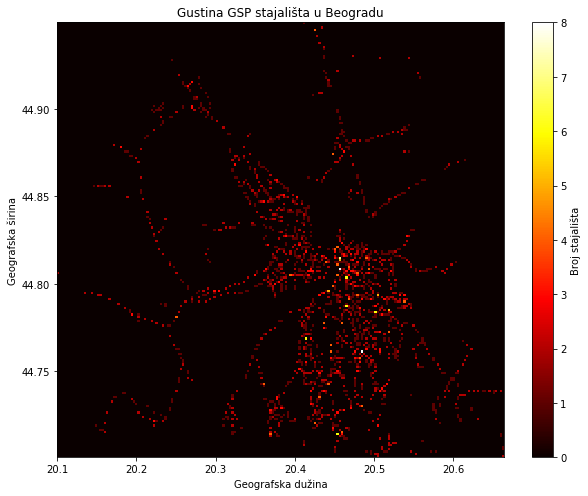

In [35]:
plt.figure(figsize=(10,8))
uslov = (stajalista['LATITUDE']<44.95)&(stajalista['LATITUDE']>44.7)&(stajalista['LONGITUDE']<22.65)&(stajalista['LATITUDE']>20.35)
data_to_plot = stajalista[uslov][['LONGITUDE','LATITUDE']].dropna()
plt.hist2d(data_to_plot['LONGITUDE'], data_to_plot['LATITUDE'], bins=200,cmap='hot')
plt.xlabel('Geografska dužina')
plt.ylabel('Geografska širina')
plt.title('Gustina GSP stajališta u Beogradu')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Broj stajališta')
plt.savefig('Gustina GSP stajališta u Beogradu.pdf',format='pdf')
plt.show()

На овој слици, где су црном бојом обојени кваратићи без стајалишта, видимо да је највећи део простора управо такав - без стајалишта. Ово је делом и очекивано, стајалишта нема у парковима, рекама, блоковима зграда, већ дуж улица и то само неких. Али, интересантно је што је тај мањи број обојених четвороуглова довољан да врло јасно и детаљно дочара мрежу улица и ослика град и његове популарне делове. 
Неки од мрачних региона на овој мапи, нису ненасељени, чак напротив, тако да нам ова мапа, заједно са неким додатним информацијама може помоћи да идентификујемо регионе којима недостаје бољи јавни градски превоз. Користите гугл претрагу и покушајте да идентификујете кључне делове ове слике - где су реке, где су неки велики паркови и шуме, где се налазе региони које смо овим дијаграмом идентификовали као најпопуларније у погледу броја стајалишта. Неки од ових одговора ће бити очигледни када ове податке прикажете на мапи. Функције за приказ података на мапи ћемо увести у радној свесци са саобраћајним незгодама, те предлажем да се вратите на неке од ових података и представите их на мапи Београда када и то савладате. За сада смо ову лепу визуализацију улица којима пролази градски превоз сачували - pdf вас очекује у локалном фолдеру!

## Задаци

1. Користећи податке о различитим линијама градског превоза које смо сумирали у табели *temp_data_per_line* пронађите које линије имају најраније јутарње поласке а које имају најкасније вечерње. Нацртајте хистограм просечног чекања на превоз користећи колону AVG_wait_time - које линије имају највеће просечно време чекања?

2. Подаци о јавном градском превозу у табели *transport_lines* садрже податке о удаљеностима сваког стајалишта од почетног стајалишта дате линије (изражено у метрима). Искористите ове податке да израчунате дужину траса линија градског превоза (помоћ: користите функције groupby и max). Представите ове податке хистограмом на коме ћете обележити просечну и медијалну вредност.

3. Нацртајте тачкасти дијаграм и дводимензионални хистограм на коме су само стајалишта из зоне 2. Обојите кружиће на тачкастом дијаграму користећи колону о броју возила која стају на стајалиште у току дана.

4. На [овој адреси](https://data.gov.rs/s/resources/linije-javnog-gradskog-prevoza/20180301-151715/LinijeJavnogGradskogPrevoza.csv) (или локално:data/LinijeJavnogGradskogPrevoza.csv) можете пронаћи сет података који садржи додатне информације о свакој линији градског превоза, укључујући и тип превоза. Откријте који све типови превоза постоје и колико има линија на којима саобраћају. Користећи ове податке издвојите информације о стајалиштима на којима стају само тролејбуси и нацртајте тачкасти дијаграм и дводимензионалних хистограм са овим стајалиштима.